In [1]:
import numpy as np

def fienup_phase_retrieval_complex(nonpadded_image, mag, osr=3, mask=None, beta=0.8, 
                           steps=200, mode='hybrid', verbose=True):
    """
    Implementation of phase-retrieval methods. This function
    implements the input-output, the output-output and the hybrid method.
    """
    
    
    assert beta > 0, 'step size must be a positive number'
    assert steps > 0, 'steps must be a positive number'
    assert mode == 'input-output' or mode == 'output-output'\
        or mode == 'hybrid',\
    'mode must be \'input-output\', \'output-output\' or \'hybrid\''
    
    if mask is None:
        mask = np.ones(mag.shape)
        
    assert mag.shape == mask.shape, 'mask and mag must have same shape'
    
    # sample random phase and initialize image x 
    np.random.seed(12)
    y_hat = mag*np.exp(1j*2*np.pi*np.random.rand(*mag.shape))
    x = np.zeros(mag.shape)
    
    # previous iterate
    x_p = None
        
    mag_ideal = np.absolute(np.fft.fft2(nonpadded_image))
    ndim = nonpadded_image.shape[0]
    F_error = np.zeros(steps+1)
    
    # main loop
    for i in range(1, steps+1):
        # show progress
        if i % 100 == 0 and verbose: 
            print("step", i, "of", steps)
        
        # inverse fourier transform
        y = np.fft.ifft2(y_hat)
        
        # previous iterate
        if x_p is None:
            x_p = y
        else:
            x_p = x 
        
        # updates for elements that satisfy object domain constraints
        if mode == "output-output" or mode == "hybrid":
            x = y
        else:    #'input-output' algorithm.
            x = x_p
                    
            
        # masking
        indices = np.logical_not(mask) 
        
        # updates for elements that violate object domain constraints
        if mode == "hybrid" or mode == "input-output":
            x[indices] = x_p[indices]-beta*y[indices] 
        elif mode == "output-output":
            x[indices] = y[indices]-beta*y[indices]
        
        # fourier transform
        x_hat = np.fft.fft2(x)
        
        # satisfy fourier domain constraints
        y_hat = mag*np.exp(1j*np.angle(x_hat))
        
        
        mag_real = np.absolute(np.fft.fft2(x[int((osr-1)*ndim/2):int((osr-1)*ndim/2)+ndim, int((osr-1)*ndim/2):int((osr-1)*ndim/2)+ndim]))
        F_error[i] = np.sum(np.absolute(mag_ideal - mag_real))/np.sum(mag_ideal)
        
    return (x, F_error)



1.3333333333333334e-06
301
(90601,)
rfieldj shape =  (301, 301)
ifieldj shape =  (301, 301)
true_fieldj shape =  (300, 300)
filedj shape = (600, 600)
Original E-filed dimension =  (600, 600)
After padding E-filed dimension =  (1200, 1200)
After padding True E-filed dimension =  (600, 600)


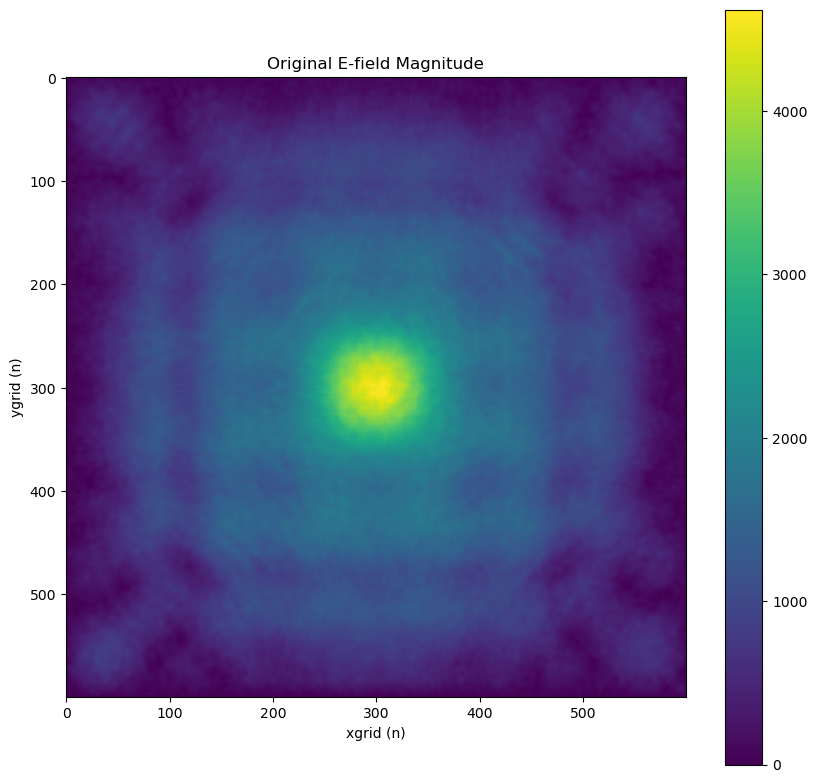

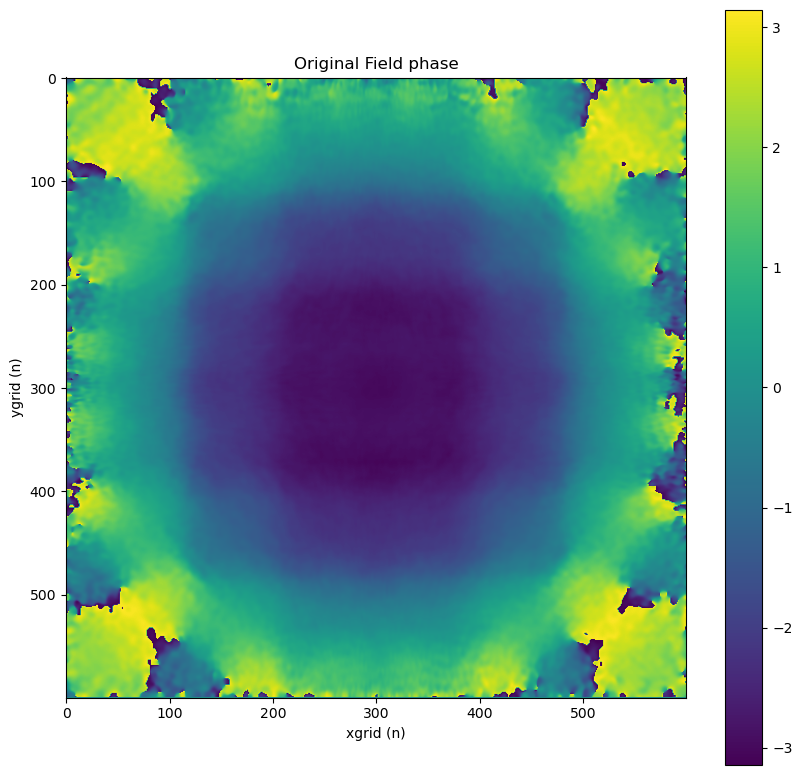

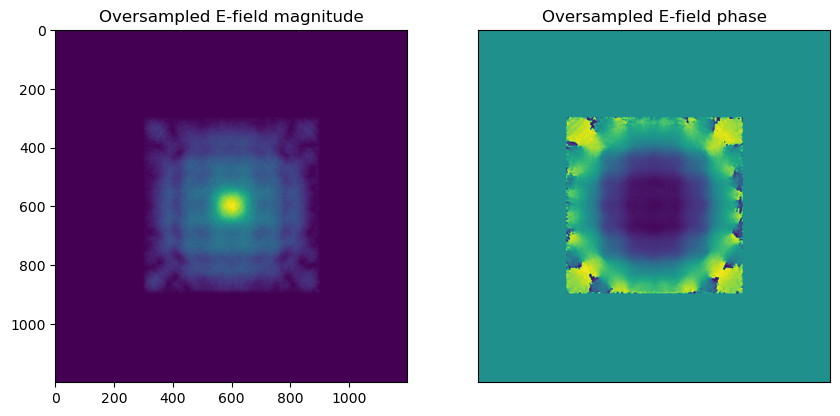

In [4]:
import numpy as np
import imageio
import h5py
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

with h5py.File('many_spikes.643.fld.h5','r') as fldj:
    
    rfieldj = fldj['slice002600/field-real'][()]
    ifieldj = fldj['slice002600/field-imag'][()]
    gridsizej = fldj['gridsize'][()][0]    
    gridpointsj= fldj['gridpoints'][()][0]
    
print(gridsizej)
print(gridpointsj)
print(rfieldj.shape)

rfieldj = rfieldj.reshape([gridpointsj,gridpointsj])
ifieldj = ifieldj.reshape([gridpointsj,gridpointsj])
print('rfieldj shape = ', rfieldj.shape)
print('ifieldj shape = ', ifieldj.shape)

true_fieldj = rfieldj[0:300, 0:300]+1j*ifieldj[0:300, 0:300]
print('true_fieldj shape = ', true_fieldj.shape)

xmaxj = (gridpointsj-1)/2*gridsizej*1e6 # unit: m=>um
xminj = -xmaxj
ymaxj = xmaxj
yminj = -ymaxj

xmaxj = (gridpointsj-1)/1
xminj = 0
ymaxj = xmaxj
yminj = 0

frj = RectBivariateSpline(np.linspace(xminj,xmaxj,301),np.linspace(yminj,ymaxj,301),rfieldj)
fij = RectBivariateSpline(np.linspace(xminj,xmaxj,301),np.linspace(yminj,ymaxj,301),ifieldj)


# interpolate
xij = np.linspace(xminj,xmaxj,600)
yij = np.linspace(yminj,ymaxj,600)

xij,yij = np.meshgrid(xij,yij)


rfieldj = frj.ev(yij,xij)
ifieldj = fij.ev(yij,xij)
    
fieldj = rfieldj+1j*ifieldj

osr=2;
image_dim=fieldj.shape
pad_fieldj = np.pad(fieldj, int((osr-1)*image_dim[0]/2), 'constant')

image_dim2 = true_fieldj.shape
true_pad_fieldj = np.pad(true_fieldj, int((osr-1)*image_dim2[0]/2), 'constant')

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(np.abs(fieldj))
plt.xlabel('xgrid (n)')
plt.ylabel('ygrid (n)')
plt.title('Original E-field Magnitude')
plt.colorbar()

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(np.angle(fieldj))
plt.xlabel('xgrid (n)')
plt.ylabel('ygrid (n)')
plt.title('Original Field phase')
plt.colorbar()

plt.figure(figsize=(10, 10), dpi=100)
plt.subplot(1,2,1)
plt.imshow(np.abs(pad_fieldj))
plt.title('Oversampled E-field magnitude')
plt.subplot(1,2,2)
plt.imshow(np.angle(pad_fieldj))
plt.title('Oversampled E-field phase')

F_Space_Mag = np.abs(np.fft.fft2(true_pad_fieldj))

ax = plt.gca()
ax.set_aspect('equal')
ax.margins(0)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

In [5]:
image2 = F_Space_Mag
print('F_space_Mag dimension = ', image2.shape)

F_space_Mag dimension =  (600, 600)


Imported F-space dimenstion =  (600, 600)
Original real-space dimension before zero-padding =  (300, 300)
Zero-padded real-space mask dimenstion =  (600, 600)
step 100 of 1000
step 200 of 1000
step 300 of 1000
step 400 of 1000
step 500 of 1000
step 600 of 1000
step 700 of 1000
step 800 of 1000
step 900 of 1000
step 1000 of 1000


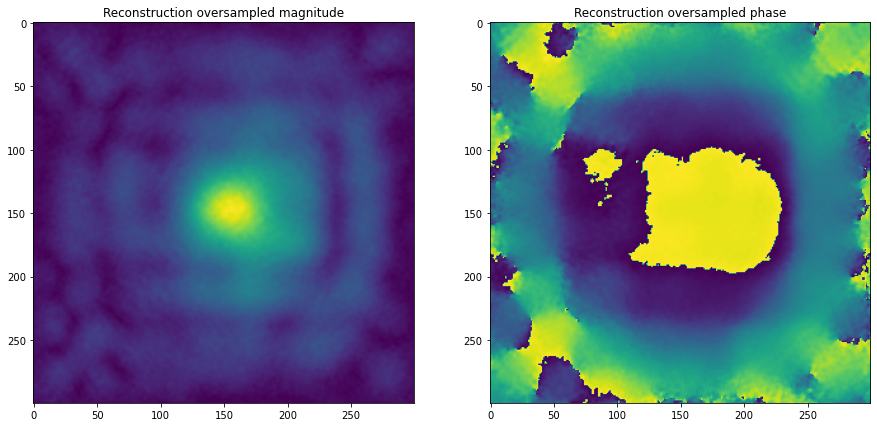

In [7]:
#Perform complex PR

ndim = image2.shape[0]  
image_in = true_fieldj
image_dim = image_in.shape[0]

mask = np.pad(np.ones((image_dim,image_dim)), int((osr-1)*image_dim/2), 'constant') #Real space mask

print('Imported F-space dimenstion = ', image2.shape)
print('Original real-space dimension before zero-padding = ', image_in.shape)
print('Zero-padded real-space mask dimenstion = ', mask.shape)

result_oversampled, F_error = fienup_phase_retrieval_complex(image_in, image2, osr=osr, beta=0.95, 
                                                             steps=1000, mode = 'hybrid', 
                                                             mask = mask, verbose=True)

low_bound = int((osr-1)*image_dim/2)
up_bound = int((osr-1)*image_dim/2)+image_dim
plt.figure(figsize=(15,15))
plt.subplot(1,2,1) 
plt.imshow(np.absolute(result_oversampled[low_bound:up_bound, low_bound:up_bound]));
plt.title('Reconstruction oversampled magnitude') 
plt.subplot(1,2,2)
plt.imshow(np.angle(result_oversampled[low_bound:up_bound, low_bound:up_bound]))
plt.title('Reconstruction oversampled phase') 
plt.show()



Text(0.5, 1.0, 'reconstructed')

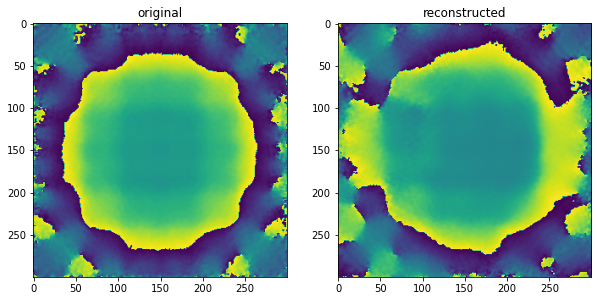

In [10]:
# Phase comparison (shifted by pi)

orig_phase = np.angle(true_fieldj)
orig_phase += np.pi
for i in range(orig_phase.shape[0]):
    for j in range(orig_phase.shape[1]):
        if orig_phase[i][j] > np.pi:
            orig_phase[i][j] = orig_phase[i][j] - 2*np.pi

recon_phase = np.angle(result_oversampled[low_bound:up_bound, low_bound:up_bound])
recon_phase += np.pi
for i in range(recon_phase.shape[0]):
    for j in range(recon_phase.shape[1]):
        if recon_phase[i][j] > np.pi:
            recon_phase[i][j] = recon_phase[i][j] - 2*np.pi

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(orig_phase)
plt.title('original')
plt.subplot(122)
plt.imshow(recon_phase)
plt.title('reconstructed')
